## <font color='darkblue'>Preface</font>
([article source](https://machinelearningmastery.com/neural-network-for-banknote-authentication/)) <font size='3ptx'>**It can be challenging to develop a neural network predictive model for a new dataset.**</font>

One approach is to first inspect the dataset and develop ideas for what models might work, then explore the learning dynamics of simple models on the dataset, then finally develop and tune a model for the dataset with a robust test harness.

This process can be used to develop effective neural network models for classification and regression predictive modeling problems.

**In this tutorial, you will discover how to develop a Multilayer Perceptron neural network model for the banknote binary classification dataset.** After completing this tutorial, you will know:
* How to load and summarize the banknote dataset and use the results to suggest data preparations and model configurations to use.
* How to explore the learning dynamics of simple MLP models on the dataset.
* How to develop robust estimates of model performance, tune model performance and make predictions on new data.

### <font color='darkgreen'>Tutorial Overview</font>
This tutorial is divided into 4 parts; they are:
* <font size='3ptx'>[**Banknote Classification Dataset**](#sect1)</font>
* <font size='3ptx'>[**Neural Network Learning Dynamics**](#sect2)</font>
* <font size='3ptx'>[**Robust Model Evaluation**](#sect3)</font>
* <font size='3ptx'>[**Final Model and Make Predictions**](#sect4)</font>

<a id='sect1'></a>
## <font color='darkblue'>Banknote Classification Dataset</font>
**The first step is to define and explore the dataset.**

We will be working with the “Banknote” standard binary classification dataset. **The banknote dataset involves predicting whether a given banknote is authentic given a number of measures taken from a photograph.**

The dataset contains 1,372 rows with 5 numeric variables. It is a classification problem with two classes (<font color='brown'>binary classification</font>). Below provides a list of the five variables in the dataset.
* variance of Wavelet Transformed image (continuous).
* skewness of Wavelet Transformed image (continuous).
* kurtosis of Wavelet Transformed image (continuous).
* entropy of image (continuous).
* class (integer).

Below is a sample of the first 5 rows of the dataset:
```csv
3.6216,8.6661,-2.8073,-0.44699,0
4.5459,8.1674,-2.4586,-1.4621,0
3.866,-2.6383,1.9242,0.10645,0
3.4566,9.5228,-4.0112,-3.5944,0
0.32924,-4.4552,4.5718,-0.9888,0
4.3684,9.6718,-3.9606,-3.1625,0
...
```

You can learn more about the dataset here:
* [Banknote Dataset (banknote_authentication.csv)](https://github.com/jbrownlee/Datasets/blob/master/banknote_authentication.csv)
* [Banknote Dataset Details (banknote_authentication.names)](https://github.com/jbrownlee/Datasets/blob/master/banknote_authentication.names)

We can load the dataset as a pandas DataFrame directly from the URL; for example:

In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from pandas import read_csv
from matplotlib import pyplot
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dropout
from kutils.analysis import histplot, barplot, boxplot, fiplot, corr 

In [2]:
# load the banknote dataset and summarize the shape

# define the location of the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/banknote_authentication.csv'
# load the dataset
df = read_csv(url, header=None)
# summarize shape
print(df.shape)

(1372, 5)


In [3]:
df.head()

,0,1,2,3,4
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In this case, we can confirm that the dataset has 5 variables (<font color='brown'>4 input and one output</font>) and that the dataset has 1,372 rows of data.

**This is not many rows of data for a neural network and suggests that a small network, perhaps with regularization, would be appropriate.**

**It also suggests that using K-fold cross-validation would be a good idea given that it will give a more reliable estimate of model performance than a train/test split and because a single model will fit in seconds instead of hours or days with the largest datasets.**

Next, we can learn more about the dataset by looking at summary statistics and a plot of the data.

In [4]:
# show summary statistics and plots of the banknote dataset
feature_columns = [0, 1, 2, 3]
target_column = [4]

## show summary statistics
print(df.describe())

                 0            1            2            3            4
count  1372.000000  1372.000000  1372.000000  1372.000000  1372.000000
mean      0.433735     1.922353     1.397627    -1.191657     0.444606
std       2.842763     5.869047     4.310030     2.101013     0.497103
min      -7.042100   -13.773100    -5.286100    -8.548200     0.000000
25%      -1.773000    -1.708200    -1.574975    -2.413450     0.000000
50%       0.496180     2.319650     0.616630    -0.586650     0.000000
75%       2.821475     6.814625     3.179250     0.394810     1.000000
max       6.824800    12.951600    17.927400     2.449500     1.000000


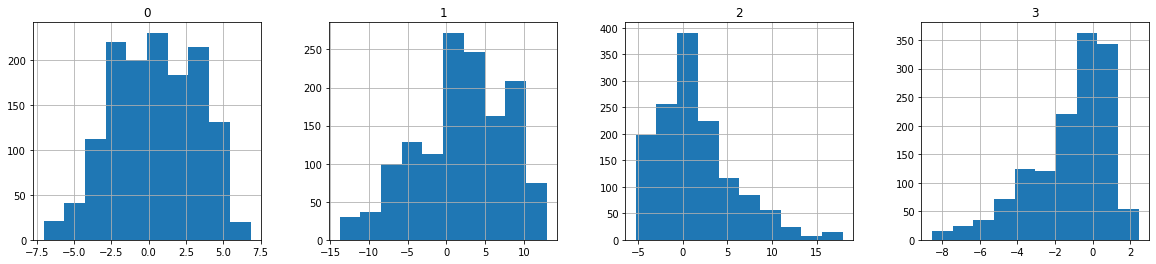

In [5]:
## plot histograms
als_hist = histplot.Utils(df)  
ax_plots = als_hist.hist(feature_columns)  

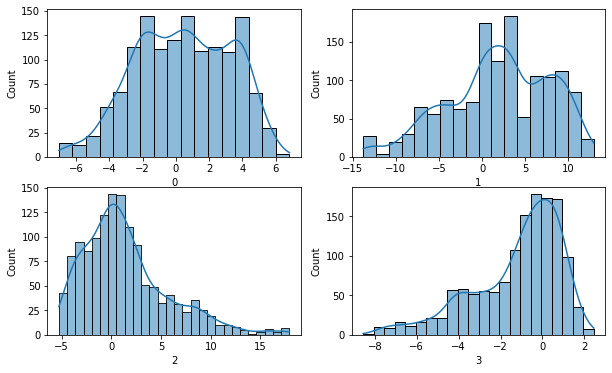

In [6]:
ax_list = als_hist.sns_hist(
    feature_columns,
    col_num=2, 
    figsize=(10, 6)
)

<font size='3ptx' color='darkred'>**Findings**</font><br/>
* We can see that perhaps the first two variables have a Gaussian-like distribution and the next two input variables may have a skewed Gaussian distribution or an exponential distribution.
* We may have some benefit in using a power transform on each variable in order to make the probability distribution less skewed which will likely improve model performance.

Now that we are familiar with the dataset, let’s explore how we might develop a neural network model.

<a id='sect2'></a>
## <font color='darkblue'>Neural Network Learning Dynamics</font>
**We will develop a Multilayer Perceptron (MLP) model for the dataset using TensorFlow.**

We cannot know what model architecture of learning hyperparameters would be good or best for this dataset, so we must experiment and discover what works well. **Given that the dataset is small, a small batch size is probably a good idea, e.g. 16 or 32 rows. Using the Adam version of stochastic gradient descent is a good idea when getting started as it will automatically adapt the learning rate and works well on most datasets.**

Before we evaluate models in earnest, **it is a good idea to review the <font color='darkblue'>learning dynamics</font> and tune the model architecture and learning configuration until we have stable learning dynamics**, then look at getting the most out of the model.

We can do this by using a simple train/test split of the data and review plots of the [**learning curves**](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/). This will help us see if we are over-learning or under-learning; then we can adapt the configuration accordingly.

First, we must ensure all input variables are floating-point values and encode the target label as integer values 0 and 1.

In [27]:
X, y = df[feature_columns], df[target_column]

# ensure all data are floating point values
X = X.astype('float32')

# encode strings to integer
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

c:\users\john\appdata\local\programs\python\python38\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
X.head()

,0,1,2,3
0,3.62160,8.6661,-2.8073,-0.44699
1,4.54590,8.1674,-2.4586,-1.46210
2,3.86600,-2.6383,1.9242,0.10645
3,3.45660,9.5228,-4.0112,-3.59440
4,0.32924,-4.4552,4.5718,-0.98880


Next, we can split the dataset into input and output variables, then into 67/33 train and test sets.

In [9]:
# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

We can define a minimal MLP model. In this case, we will use one hidden layer with 10 nodes and one output layer (<font color='brown'>chosen arbitrarily</font>). We will use the [ReLU activation function](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/) in the hidden layer and the “he_normal” weight initialization, as together, they are a good practice.

In [10]:
def get_mlp_model():
    # determine the number of input features
    n_features = X.shape[1]

    # define model
    model = keras.Sequential()
    model.add(layers.Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
    model.add(layers.Dense(1, activation='sigmoid'))
    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy')
    
    return model

In [11]:
mlp_model = get_mlp_model()
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                50        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


We will fit the model for 50 training epochs (<font color='brown'>chosen arbitrarily</font>) with a batch size of 32 because it is a small dataset. **We are fitting the model on raw data, which we think might be a good idea, but it is an important starting point.**

In [12]:
# fit the model
history = mlp_model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=32, 
    verbose=0, 
    validation_data=(X_test,y_test)
)

At the end of training, we will evaluate the model’s performance on the test dataset and report performance as the classification accuracy.

In [13]:
# predict test set
yhat = mlp_model.predict(X_test)

In [14]:
# Translate probability of class 1 into class prediction. (prob > 0.5-> 1 otherwise 0)
y_pred = yhat > 0.5

In [15]:
# evaluate predictions
score = accuracy_score(y_test, y_pred)
print('Accuracy: %.3f' % score)

Accuracy: 1.000


In this case, we can see that the model achieved great or perfect accuracy of 99% percent. This might suggest that the prediction problem is easy and/or that neural networks are a good fit for the problem.

Finally, we will **plot learning curves of the cross-entropy loss on the train and test sets during training**.

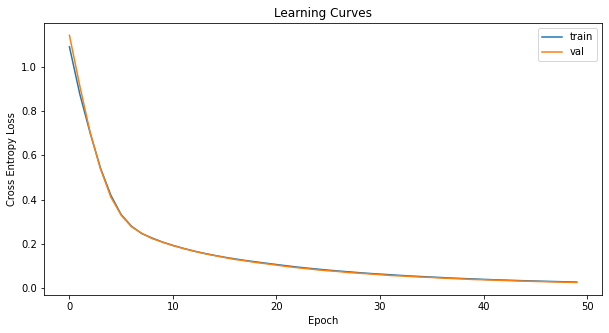

In [16]:
# plot learning curves
plt.rcParams['figure.figsize'] = [10, 5]
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

We can see that the model appears to converge well and does not show any signs of overfitting or underfitting.

We did amazingly well on our first try. **Now that we have some idea of the learning dynamics for a simple MLP model on the dataset, we can look at developing a more robust evaluation of model performance on the dataset.**

<a id='sect3'></a>
## <font color='darkblue'>Robust Model Evaluation</font>
**[The k-fold cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation) procedure can provide a more reliable estimate of MLP performance, although it can be very slow.**

This is because k models must be fit and evaluated. This is not a problem when the dataset size is small, such as the banknote dataset.

We can use the [**StratifiedKFold**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) class and enumerate each fold manually, fit the model, evaluate it, and then report the mean of the evaluation scores at the end of the procedure.

In [17]:
# prepare cross validation
skf = StratifiedKFold(n_splits=2)

# enumerate splits
scores = list()
for train_ix, test_ix in skf.split(X, y):
    # fit and evaluate the model...
    mlp_model = get_mlp_model()
    
    # split data
    X_train, X_test, y_train, y_test = X.iloc[train_ix], X.iloc[test_ix], y[train_ix], y[test_ix]
    history = mlp_model.fit(
        X_train, 
        y_train, 
        epochs=50, 
        batch_size=32, 
        verbose=0, 
        validation_data=(X_test,y_test)
    )
    
    yhat = mlp_model.predict(X_test)
    y_pred = yhat > 0.5
    score = accuracy_score(y_test, y_pred)
    scores.append(score)

In [18]:
# summarize all scores
scores = np.array(scores)
print(f'Mean Accuracy: {scores.mean():.03f} (std={scores.std():.03f})')

Mean Accuracy: 0.989 (std=0.005)


**We can use this framework to develop a reliable estimate of MLP model performance with our base configuration**, and even with a range of different data preparations, model architectures, and learning configurations.

In this case, we can see that **the MLP model achieved a mean accuracy of about 98.9 percent.**

This confirms our expectation that the base model configuration works very well for this dataset, and indeed the model is a good fit for the problem and perhaps the problem is quite trivial to solve.

Next, let’s look at how we might fit a final model and use it to make predictions.

<a id='sect4'></a>
## <font color='darkblue'>Final Model and Make Predictions</font>
**Once we choose a model configuration, we can train a final model on all available data and use it to make predictions on new data.**

In this case, we will use the model with [**dropout**](https://keras.io/api/layers/regularization_layers/dropout/) and a small batch size as our final model.

We can prepare the data and fit the model as before, although on the entire dataset instead of a training subset of the dataset.

In [23]:
def get_mlp_model_with_dropout_layer(dropout_rate=0.2):
    # determine the number of input features
    n_features = X.shape[1]

    # define model
    model = keras.Sequential()
    model.add(Dropout(dropout_rate, input_shape=(n_features,)))
    model.add(layers.Dense(10, activation='relu', kernel_initializer='he_normal'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy')
    
    return model

In [24]:
mlp_model = get_mlp_model_with_dropout_layer()

history = mlp_model.fit(
    X, 
    y, 
    epochs=50, 
    batch_size=32, 
    verbose=0,    
)

In [28]:
# define a row of new data
row = [3.6216,8.6661,-2.8073,-0.44699]

# make prediction
yhat = mlp_model.predict_classes([row])

# invert transform to get label for class
yhat = le.inverse_transform(yhat)

# report prediction
print('Predicted: %s' % (yhat[0]))

Predicted: 0


c:\users\john\appdata\local\programs\python\python38\lib\site-packages\sklearn\preprocessing\_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In this case, we can see that the model predicted a “0” label for input feature vector as `[3.6216,8.6661,-2.8073,-0.44699]`

## <font color='darkblue'>Supplement</font>
* [How to Visualize a Deep Learning Neural Network Model in Keras](https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/)
* [Dropout Regularization in Deep Learning Models With Keras](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/)
* [機器學習中可視化Keras中的各種過濾器初始化程序簡介（附代碼）](https://kknews.cc/zh-tw/code/4k9ermv.html)
* [How to Develop a Neural Net for Predicting Disturbances in the Ionosphere](https://machinelearningmastery.com/predicting-disturbances-in-the-ionosphere/)
* [Best Results for Standard Machine Learning Datasets](https://machinelearningmastery.com/results-for-standard-classification-and-regression-machine-learning-datasets/)
* [TensorFlow 2 Tutorial: Get Started in Deep Learning With tf.keras](https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/)
* [A Gentle Introduction to k-fold Cross-Validation](https://machinelearningmastery.com/k-fold-cross-validation/)